### Import des libraires
- Pandas : gestion heterogène array
- Numpy : gestion homogène array
- Torch : ML/DL pour création de nn, transformation audio
- Matplotlib : Pour plot des données
- Tqdm : bar de chargement entrainement

In [1]:
import csv
import os
from pathlib import Path

import torch
from torch import Tensor
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from typing import Dict, List, Tuple, Union

from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchaudio.transforms import MelSpectrogram
import torchaudio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchaudio.transforms as T

from tqdm import tqdm



/Users/robinbochu/.pyenv/versions/3.11.8/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


On définit le device sur mps étant sur un silicon pour faire de la parralélisation

In [2]:
device = torch.device("mps")

### Dataset
Contexte de la donnée:
On a 3 datasets utilisable : test, train, validated. J'ai donc décidé de les concaténer pour finalement avoir un dataset beaucoup plus grand comme ça on facilite la segmentation de la donnée : 80/20%

- Récupération de la donnée dans les fichier tsv
- Cleanning de la data (Valeurs null ou à 0)
- Filtre données : on ne garde que les target = 1, 2, 3 ou 4

In [3]:
validate_data = pd.read_csv('data/cv-corpus-7.0-singleword/fr/validated.tsv',sep='\t')
validate_data[['path', 'sentence']] = validate_data[['path', 'sentence']].replace('', np.nan)
validate_data_numbers = validate_data[(validate_data['sentence']=='un')|(validate_data['sentence']=='deux')|(validate_data['sentence']=='trois')|(validate_data['sentence']=='quatre')]

validate_data_numbers.dropna(subset=['sentence', 'path'], inplace=True)

print(f"validate rows: {validate_data_numbers.shape[0]}")



validate rows: 8652


/var/folders/j3/tchtxx29319gbp_dsgcljm800000gn/T/ipykernel_20687/2388788656.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate_data_numbers.dropna(subset=['sentence', 'path'], inplace=True)


In [4]:
print(validate_data_numbers['sentence'].value_counts())

sentence
deux      1492
trois     1453
quatre    1445
oui       1440
non       1439
un        1383
Name: count, dtype: int64


### Fonction pour load les mp3
```python3  
def Load_waveform() 
```
Convertit un mp3 en waveform (manipulable en code)

-----------------------------------------------------------------------------

```python3  
def Load_waveformes() 
```
Itère dans les 3 datasets et convertit tous les fichiers

In [5]:
def load_waveform(mp3_file):
    waveform, sample_rate = torchaudio.load(mp3_file, format='mp3')
    return waveform, sample_rate

def load_waveformes(df,waveformes,targets):
    for mp3_path in df['path']:
        waveform, _ = load_waveform(f'data/cv-corpus-7.0-singleword/fr/clips/{mp3_path}')
        waveformes.append(waveform)
        targets.append(df[df['path'] == mp3_path]['sentence'].values[0])


### Création des array contenant toutes nos données 
On pourra transformer ces array en TorchDataset plus tard ce qui va faciliter la compréhension

In [6]:
waveformes = []
targets = []
load_waveformes(validate_data_numbers,waveformes,targets)

print(f"waveformes: {len(waveformes)}")
print(f"targets: {len(targets)}")

waveformes: 8652
targets: 8652


In [7]:
new_files_path = ['1.mp3', '12.mp3','13.mp3','2.mp3','22.mp3','23.mp3','3.mp3', '32.mp3', '33.mp3','4.mp3','42.mp3','43.mp3']
new_files_labels = ['un','un','un','deux','deux','deux','trois','trois','trois','quatre','quatre','quatre']
new_audio = []
for i in range (0,100):
    for i in new_files_path:
        waveform, _ = load_waveform(f'data/{i}')
        waveformes.append(waveform)
        targets.append(new_files_labels[new_files_path.index(i)])

In [8]:
waveform, sr = load_waveform(f'data/1.mp3')
print(sr)

44100


### Petit check si les données sont bien équilibré 
Si le nombre de données est différent d'une classe à l'autre alors notre modèle sera biaisé 

([<matplotlib.axis.XTick at 0x16aaedb10>,
 [Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3'), Text(4, 0, '4')])

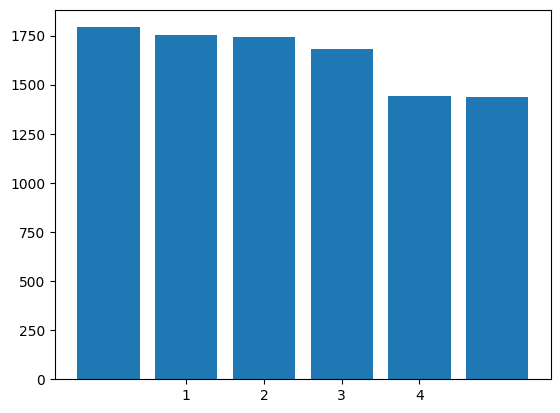

In [9]:
count=pd.Series(targets).value_counts()
plt.bar(count.index,count.values)
plt.xscale('linear')
plt.xticks(range(1,5,1))

### String -> Numeric
On va map nos données target pour faciliter l'entrainement de notre modèle
Celui-ci va prédir une donnée numérique en output et on calculera la loss par rapport à la value de la classe correspondante

In [10]:
map = {
    'un': 0,
    'deux': 1,
    'trois': 2,
    'quatre': 3,
    'oui': 4,
    'non': 5
}

targets = [map[i] for i in targets]

### Transformation de nos waveform en spectrogram

In [11]:
transform = MelSpectrogram(sample_rate=44100, n_mels=40, n_fft=512, hop_length=256)
spectrograms = [transform(wave).squeeze(0) for wave in waveformes]

### Normalisation des données (Pour un CNN 25% -> 75% avec une normalisation standard)

In [12]:
def normalize_spectrograms(spectrograms):
    normalized_spectrograms = []
    for s in spectrograms:
        s_max = s.max()
        s_min = s.min()
        normalized_spectrograms.append((s - s_min)/(s_max-s_min))
    return normalized_spectrograms

spectrograms = normalize_spectrograms(spectrograms)

In [13]:
print(spectrograms[1].shape)

torch.Size([40, 374])


In [14]:
print(spectrograms[0].shape)
print(spectrograms[0].shape[1])

torch.Size([40, 586])
586


In [15]:
max = 0
for mel in spectrograms:
    if mel.shape[1] > max:
        max = mel.shape[1]
print(max)

2021


### On transpose notre tensor pour avoir les time frame en première dimension 

In [16]:
spectrograms = [mel.transpose(0, 1) for mel in spectrograms]
print(spectrograms[0].shape)

torch.Size([586, 40])


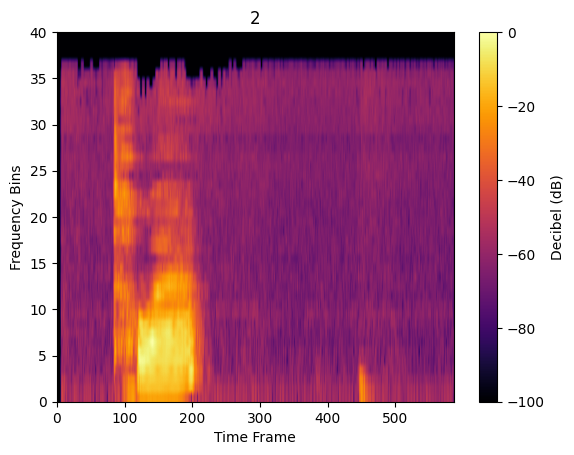

In [17]:
def plot_spectrogram(spec, title=None, ylabel='Frequency Bins', aspect='auto', xmax=None):
    """
    Plots a spectrogram with the time axis on the x-axis and frequency bins on the y-axis.
    
    Parameters:
        spec (np.ndarray or torch.Tensor): The spectrogram tensor/array.
        title (str, optional): Title of the plot.
        ylabel (str, optional): Label for the y-axis.
        aspect (str, optional): Aspect ratio of the plot. 'auto' fills the axes with the data.
        xmax (int, optional): Maximum value for the x-axis (time axis).
    """
    # Transform amplitude spectrogram to decibel scale
    spec_to_db = T.AmplitudeToDB(stype='power')
    spec_db = spec_to_db(spec)

    # Check if the input is a tensor and convert to numpy for plotting
    if isinstance(spec_db, torch.Tensor):
        spec_db = spec_db.numpy()

    # Transpose the spectrogram to align time on the x-axis and frequency bins on the y-axis
    spec_db = spec_db.T  # now the shape should be [time, frequency]

    # Create the plot
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (dB)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('Time Frame')
    
    # Adjust the extent to properly scale the axes, with time on the x-axis and frequency on the y-axis
    cax = axs.imshow(spec_db, aspect=aspect, origin='lower',
                     extent=[0, spec_db.shape[1], 0, spec_db.shape[0]],
                     cmap='inferno')
    
    # Set maximum x-axis value if provided
    if xmax:
        axs.set_xlim([0, xmax])
    
    # Add a colorbar to the plot to indicate the decibel scale
    fig.colorbar(cax, label='Decibel (dB)')
    plt.show()

plot_spectrogram(spectrograms[0].squeeze(0), title=targets[0])

### Padding 
Pour avoir des séquence de même données 

In [18]:
def pad(spectrograms,max):
    padded_spectrograms = []
    for mel in spectrograms:
        padded_spectrograms.append(F.pad(mel, (0, 0, 0, max-mel.shape[0])))
    return padded_spectrograms
padded_spectrograms = pad(spectrograms,max)

In [19]:
print(padded_spectrograms[1].shape)


torch.Size([2021, 40])


### Séparation 80/20

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_spectrograms, targets, test_size=0.2, random_state=42)

In [21]:
print(len(X_train))
print(len(X_test))

7881
1971


In [22]:
# Stack permet de transformer une liste de tensor en un seul tensor
X_train_tensor = torch.stack(X_train)
X_test_tensor = torch.stack(X_test)  

y_train_tensor = torch.tensor(y_train).long() 
y_test_tensor = torch.tensor(y_test).long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
print(len(train_dataset))
print(len(test_dataset))

7881
1971


In [23]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

## CNN 

In [24]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5), stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=(4, 2), stride=(4, 2))

        self.conv2 = nn.Conv2d(8, 16, kernel_size=(5, 5), stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=(4, 2), stride=(4, 2))
        self.flattened_size = 16 * 126 * 10

        self.fc1 = nn.Linear(self.flattened_size, 2048)
        self.fc2 = nn.Linear(2048, num_classes)
        self.dropout = nn.Dropout(0.3)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout(x)
        x = x.view(-1, self.flattened_size) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
cnn = SimpleCNN(6).to(device)

### Function Train/Test

In [25]:
def train_cnn(model, train_loader, optimizer, criterion, epochs=20):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        with tqdm(train_loader, unit="batch") as tepoch:
            for spectrograms, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")
                
                spectrograms = spectrograms.to(device)
                labels = labels.to(device)
                outputs = model(spectrograms.unsqueeze(1))  
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())
        
        # Average loss for this epoch
        average_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1} completed: Avg. Loss: {average_loss:.4f}")

In [26]:
def test_cnn(model, test_loader):
    with torch.no_grad():
        acc_total = 0
        model.eval()
        for spectrograms, labels in test_loader:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)
            outputs = model(spectrograms.unsqueeze(1))
            _, predicted = torch.max(outputs, 1)
            acc_total += (predicted==labels).sum().item()/len(labels)
        print(f"Accuracy: {acc_total/len(test_loader)}")

### Train/Test

In [27]:
# Train CNN
optimizer = torch.optim.AdamW(lr=0.01, params=cnn.parameters())
criterion = nn.CrossEntropyLoss()
train_cnn(cnn, train_loader, optimizer, criterion, epochs=20)

Epoch 1: 100%|██████████| 62/62 [00:11<00:00,  5.53batch/s, loss=1.81]


Epoch 1 completed: Avg. Loss: 3.2673


Epoch 2: 100%|██████████| 62/62 [00:09<00:00,  6.36batch/s, loss=1.8] 


Epoch 2 completed: Avg. Loss: 1.7888


Epoch 3: 100%|██████████| 62/62 [00:09<00:00,  6.53batch/s, loss=1.79]


Epoch 3 completed: Avg. Loss: 1.7886


Epoch 4: 100%|██████████| 62/62 [00:09<00:00,  6.53batch/s, loss=1.79]


Epoch 4 completed: Avg. Loss: 1.7883


Epoch 5: 100%|██████████| 62/62 [00:09<00:00,  6.40batch/s, loss=1.78]


Epoch 5 completed: Avg. Loss: 1.7883


Epoch 6:  23%|██▎       | 14/62 [00:02<00:07,  6.37batch/s, loss=1.79]


KeyboardInterrupt: 

In [ ]:
# Test CNN
test_cnn(cnn, test_loader)

Accuracy: 0.8552083333333333


## LSTM

In [ ]:
print(train_dataset[0][0].shape[1])

40


In [28]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, sequence_length, dropout):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.sequence_length = sequence_length
        self.dropout = dropout
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size*sequence_length, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, (_,_) = self.lstm(x, (h0, c0))
        # out = self.fc(out[:, -1, :])
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

In [29]:
acc = []
def train_lstm(model, train_loader, optimizer, criterion, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        with tqdm(train_loader, unit="batch") as tepoch:
            for spectrograms, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")
                spectrograms = spectrograms.to(device)
                labels = labels.to(device)
                outputs = model(spectrograms)  
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())
        
        # Average loss for this epoch
        average_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1} completed: Avg. Loss: {average_loss:.4f}")
        acc.append(average_loss)

In [ ]:
def test_lstm(model, test_loader):
    with torch.no_grad():
        acc_total = 0
        model.eval()
        for spectrograms, labels in test_loader:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)
            outputs = model(spectrograms)
            _, predicted = torch.max(outputs, 1)
            acc_total += (predicted==labels).sum().item()/len(labels)
        print(f"Accuracy: {acc_total/len(test_loader)}")

In [ ]:
num_layers = 4
hidden_size = 50

# Input_size = n filter
input_size = train_dataset[0][0].shape[1]

# Séquence length = padding = 2021
sequence_length = train_dataset[0][0].shape[0]
num_classes = 4
dropout = 0.2
lr = 0.01
num_epochs = 10


lstm = LSTM(input_size, hidden_size, num_layers, num_classes, sequence_length, dropout)
# lstm.load_state_dict(torch.load('last-day-2-92.pth'))
lstm.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr=lr)
train_lstm(lstm, train_loader, optimizer, criterion, epochs=num_epochs)


In [ ]:
test_lstm(lstm, test_loader)

In [ ]:
torch.save(lstm.state_dict(), 'last-day-2-92.pth')